# <img src="assets/ufscar.png" alt="Logo UFScar" width="200" align="left"/><p><center>Universidade Federal de São Carlos (UFSCar)</center><br/><font size="4"><center> Departamento de Computação, campus Sorocaba </center> </font>


<font size="4"><center><b>Disciplina: Aprendizado de Máquina</b></center></font>
<font size="3"><center>Prof. Dr. Tiago A. Almeida</center></font>
</p>

<br>
<font size = "4"><center><b> Grupo 5: Análise de sentimento de reviews na Amazon </b></center></font>
<br>

# Support Vector Machine

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pre_processing as pp
import analysis as anl
import pca

# SVM
import svmutil
from svmutil import svm_read_problem
from svmutil import svm_problem
from svmutil import svm_parameter
from svmutil import svm_train
from svmutil import svm_predict
from svmutil import svm_save_model

# Categoria da base de dados a ser lida (do disco) e processada
# [books, kitchen_&_housewares, electronics, dvd, all]
category = 'test'

# Se positivo, adiciona bigramas para reviews negativas
# ex: ('not', 'good') equivale a uma única feature
hNeg = True

# Se positivo, adiciona substantivos
noun = False

# Guarda as features ja processadas em X, a classe da amostra em Y e o vocabulario em vocabulary
# hNeg e noun sao opcionais, por padrao hNeg=True, noun=False
X, Y, vocabulary = pp.bow(category, hNeg, noun)

print("Vocabulário possui " + str(len(vocabulary)) + " palavras!")

Vocabulário possui 1509 palavras!


#### Separa os dados em treinamento e teste:

In [2]:
# semente usada na randomizacao dos dados.
randomSeed = 10 

# gera os indices aleatorios que irao definir a ordem dos dados
idx_perm = np.random.RandomState(randomSeed).permutation(range(len(Y)))

# ordena os dados de acordo com os indices gerados aleatoriamente
X2, Y2 = X[idx_perm, :], Y[idx_perm]

# Porcentagem de amostras destinadas a base de treino
pTrain = 0.8

# Executa o holdout e retorna os indices de treino e teste, mantendo a proporcao original entre as classes
train_index, test_index = anl.stratified_holdOut(Y, pTrain)

# Guarda as amostras de treino e teste
Xtrain, Xval = X2[train_index, :], X2[test_index, :]
Ytrain, Yval = Y2[train_index], Y2[test_index]

#### Seleciona features com chi-quadrado (a partir dos dados de treinamento):

In [3]:
# Seta o valor de alpha para o chi-quadrado. 
# alpha e opcional, por padrão alpha = 0.05
alpha = 0.05

# Chama a funcao para executar o chi-quadrado e retorna a nova base de dados reduzida
# o novo vocabulario e os indices das features mantidas
Xtrain, new_vocabulary, index = pp.chi2(Xtrain, Ytrain, vocabulary, alpha)

# Seleciona apenas as features do indice retornado pelo chi-quadrado para a base de teste
Xval = Xval[:, index]

#converte para outro tipo de matriz esparsa que facilita os cálculos do svm
Xtrain = Xtrain.tolil() 
Xval = Xval.tolil()

In [4]:
print("Número de features antes do chi-quadrado: " + str(len(vocabulary)))
print("----------------------------------------")
print("Número de features após chi-quadrado: " + str(len(new_vocabulary)))
print(new_vocabulary)

Número de features antes do chi-quadrado: 1509
----------------------------------------
Número de features após chi-quadrado: 26
['bad', 'wild', 'heal', 'well', 'hormon', 'not', 'arab', 'whole', 'explain', 'said', 'less', 'true', 'good', 'eat', 'paleolith', 'tri', 'love', 'wish', 'pain', 'mean', 'entir', 'die', 'written', 'wast', 'legal', 'horribl']


### Gridsearch
Itera sobre uma lista de possíveis valores para custo e gamma, e retorna a melhor combinação

In [5]:
def gridSearch(X, Y, Xval, Yval):
    #inicializa as variáveis que deverão ser retornadas pela função
    custo = 1000
    gamma = 1000
    
    values = [0.01, 0.05, 0.1, 0.5, 10, 50, 100, 500]
    
    acr = 0
    
    for i in values:
        for j in values:
            model = svm_train(Y, X, '-c %f -g %f -q' %(i, j))
            classes = svm_predict([], Xval, model, '-q')
            acuracia = np.sum(np.array(classes[0])==Yval)/len(Yval)
            if acr < acuracia:
                custo = i
                gamma = j
                acr = acuracia
                    
    return custo, gamma

## Treinamento e predição SVM:
Treina e retorna o modelo de predição da SVM, de acordo com os valores de custo e gamma encontrados no GridSearch

In [6]:
def svm(Xtrain, Ytrain, Xval, Yval) :

    # Executa o gridSearch para retornar os melhores valores de custo e gamma
    bestC, bestGamma = gridSearch(Xtrain, Ytrain, Xval, Yval)
    
    kernel = 2 #kernel radial
    
    # Treina a svm com os melhores valores de custo e gamma e guarda o modelo
    model = svm_train(Ytrain, Xtrain, '-c %f -t %d -g %f -q' %(bestC, kernel, bestGamma))
    
    # Realiza a predição
    classes = svm_predict([], Xval, model, '-q')
    
    # Calcula a acurácia
    acuracia = np.sum(np.array(classes[0])==Yval)/len(Yval)

    return np.array(classes[0], dtype="int"), acuracia

#### Predição da base de teste do Holdout:

In [7]:
Ypred, acuracia = svm(Xtrain,Ytrain,Xval,Yval)
print("Acurácia é "+ str(acuracia*100))

classes = np.unique(Y)
auxResults = anl.relatorioDesempenho(Yval, Ypred, classes, imprimeRelatorio=True)

Acurácia é 75.0

	Revocacao   Precisao   F-medida   Classe
	0.750       0.750      0.750      0
	0.750       0.750      0.750      1
	------------------------------------------------
	0.750       0.750      0.750      Média macro
	0.750       0.750      0.750      Média micro

	Acuracia: 0.750


## Curva de Aprendizado:

In [8]:
def curva_aprendizado(X, Y, Xval, Yval, num_iteracoes = 0):
   
    """
    Funcao usada gerar a curva de aprendizado.
  
    Parametros
    ----------
  
    X : matriz com os dados de treinamento
  
    Y : vetor com as classes dos dados de treinamento
  
    Xval : matriz com os dados de validação
  
    Yval : vetor com as classes dos dados de validação
    
    num_iteracoes : escalar indicando a quantidade de iterações
  
    """

    # Define a quantidade de iteracoes, por padrão, itera por cada amostra da base de treino
    if (num_iteracoes <= 0 or num_iteracoes > len (Y)):
        num_iteracoes = len (Y)    
    
    # inicializa as listas que guardarao a performance no treinamento e na validacao
    perf_train = []
    perf_val = []

    # Guarda a quantidade de classes da base
    classes = np.unique(Y)
    
    
    # Itera e executa o classificador naive bayes com i amostras da base de treino para cada iteracao
    for i in range(10, len(Y), int (len(Y)/num_iteracoes)):
        
        # Treina e faz a predicao
        Ypred, acuracia = svm(X[:i],Y[:i],X[:i],Y[:i])
        
        # Guarda a acuracia da iteracao usando a base de treino como teste
        perf_train.append(acuracia)

        # Treina e faz a predicao
        Ypred, acuracia = svm(X[:i],Y[:i],Xval,Yval)
        
        # Guarda a acuracia da iteracao usando a base de validacao como teste
        perf_val.append(acuracia)

    ##################################################################################
       
    # Define o tamanho da figura 
    plt.figure(figsize=(20,12))

    # Plota os dados
    plt.plot(perf_train, color='blue', linestyle='-', linewidth=1.5, label='Treino') 
    plt.plot(perf_val, color='red', linestyle='-', linewidth=1.5, label='Validação')

    # Define os nomes do eixo x e do eixo y
    plt.xlabel(r'# Qtd. de dados de treinamento',fontsize='x-large') 
    plt.ylabel(r'Acuracia',fontsize='x-large') 

    # Define o título do gráfico
    plt.title(r'Curva de aprendizado', fontsize='x-large')

    # Acrescenta um grid no gráfico
    plt.grid(axis='both')

    # Plota a legenda
    plt.legend()
    
    plt.show()



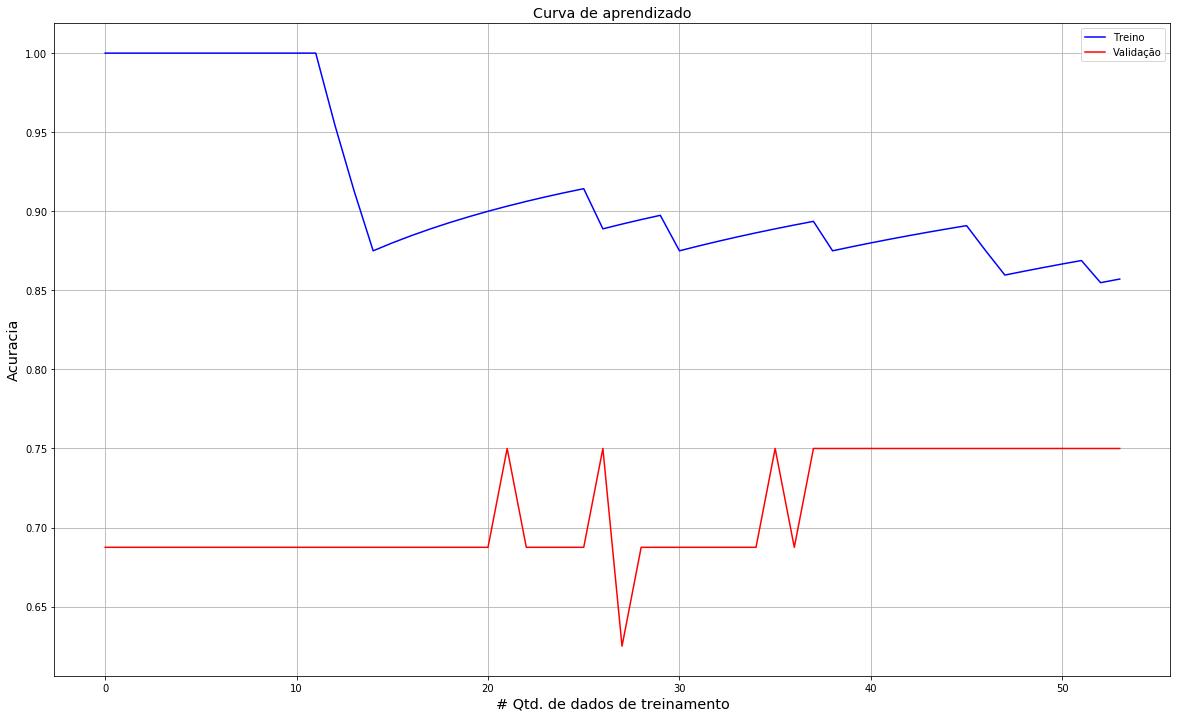

In [9]:
# num_iteracoes = numero de iterações da curva de aprendizado, por padrao e igual ao numero de amostras da base
curva_aprendizado(Xtrain, Ytrain, Xval, Yval, num_iteracoes = 100)

## K-Folds

In [10]:
import k_folds as kf

#Pega todos os tipos de classes 
classes = classes = np.unique(Y)

# semente usada na randomizacao dos dados.
randomSeed = 10 

# gera os indices aleatorios que irao definir a ordem dos dados
idx_perm = np.random.RandomState(randomSeed).permutation(range(len(Y)))

# ordena os dados de acordo com os indices gerados aleatoriamente
X3, Y3 = X[idx_perm, :], Y[idx_perm]

# separa os dados em k folds
nFolds = 5
folds = kf.stratified_kfolds(Y3, nFolds, classes)

k = 1

# cria uma lista vazia para guardar os resultados obtidos em cada fold
resultados=[] 

for train_index, test_index in folds:

    print('\n-----------\n%d-fold: \n-----------\n' % (k) )

    # se train_index ou test_index forem vazios, interrompe o laco de repeticao
    if len(train_index)==0 or len(test_index)==0: 
        print('\tErro: o vetor com os indices de treinamento ou o vetor com os indices de teste esta vazio')      
        break
        
        
    # Guarda as bases de treino e teste baseado nos índices de cada fold
    Xtrain, Xval = X3[train_index, :], X3[test_index, :];
    Ytrain, Yval= Y3[train_index], Y3[test_index];

    
    # Executa o chi-quadrado na base do fold atual
    Xtrain, new_vocabulary, index = pp.chi2(Xtrain, Ytrain, vocabulary)
    Xval = Xval[:, index]
    
    # Converte para outro tipo de matriz esparsa que facilita os cálculos do svm
    Xtrain = Xtrain.tolil() 
    Xval = Xval.tolil()

    # Execucao da SVM
    Ypred, acuracia = svm(Xtrain, Ytrain, Xval, Yval)
    
    # Relatorio do fold
    auxResults = anl.relatorioDesempenho(Yval, Ypred, classes, imprimeRelatorio=True)

    # adiciona os resultados do fold atual na lista de resultados
    resultados.append( auxResults )
    
    k = k + 1
    
kf.mediaFolds( resultados, classes )


-----------
1-fold: 
-----------


	Revocacao   Precisao   F-medida   Classe
	0.500       1.000      0.667      0
	1.000       0.692      0.818      1
	------------------------------------------------
	0.750       0.846      0.795      Média macro
	0.765       0.765      0.765      Média micro

	Acuracia: 0.765

-----------
2-fold: 
-----------


	Revocacao   Precisao   F-medida   Classe
	1.000       0.615      0.762      0
	0.375       1.000      0.545      1
	------------------------------------------------
	0.688       0.808      0.743      Média macro
	0.688       0.688      0.688      Média micro

	Acuracia: 0.688

-----------
3-fold: 
-----------


	Revocacao   Precisao   F-medida   Classe
	0.750       0.667      0.706      0
	0.625       0.714      0.667      1
	------------------------------------------------
	0.688       0.690      0.689      Média macro
	0.688       0.688      0.688      Média micro

	Acuracia: 0.688

-----------
4-fold: 
-----------


	Revocacao   Precisao 